# FC3 - Genetic Algorithm
Angel Adrian Pimienta Flores

ID: 167210

This section details the importation of necessary Python libraries essential for the execution of the genetic algorithm.

In [16]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt

## Class Definitions#### Metro Station Class

This class encapsulates the concept of a metro station. Each station is initialized with its name and a dictionary detailing the travel times to adjacent stations, providing a means to retrieve travel time efficientlthon

In [17]:
class Station:
    # Start of the Station class definition
    def __init__(self, name, neighbors):
        # Constructor method with two parameters: name (string) and neighbors (dictionary)
        self.name = name  # Initialize the 'name' attribute with the provided 'name' argument
        self.neighbors = neighbors  # Initialize the 'neighbors' attribute with the provided 'neighbors' dictionary

    def distance(self, station):
        # Define a method to calculate the travel time to another station
        return self.neighbors.get(station.name, float('inf'))  # Return the travel time to the station passed as an argument.
                                                              # If the station is not a direct neighbor, return infinity.

    def __repr__(self):
        # Define the official string representation method of the Station object
        return self.name  # Return the name of the station as its string representation


#### Route Fitness Evaluator Class
This class assesses the viability of a route through the metro network. It calculates the total travel time of the route and determines its fitness, an inverse value that aids the genetic algorithm in optimizing for the shortest path.

In [18]:
class Fitness:
    # Define the Fitness class which is used to evaluate the 'fitness' of a specific route.
    def __init__(self, route):
        # Constructor method that initializes an instance of Fitness with the provided route.
        self.route = route  # Stores the route, which is a list of Station objects.
        self.distance = 0  # Initialize the 'distance' attribute to 0. This will store the total travel time of the route.
        self.fitness = 0.0  # Initialize the 'fitness' attribute to 0.0. This is a measure of the route's efficiency.

    def routeDistance(self):
        # Define a method to calculate the total travel time of the route.
        if self.distance == 0: 
            # Only calculate the distance if it has not already been calculated.
            pathDistance = 0  # Initialize a variable to accumulate the total travel time.
            for i in range(0, len(self.route) - 1):
                # Iterate through pairs of consecutive stations in the route.
                pathDistance += self.route[i].distance(self.route[i + 1])
                # Add the distance (travel time) between consecutive stations to the total.
            self.distance = pathDistance  # Store the total calculated distance in the attribute.
        return self.distance  # Return the total distance for this route.

    def routeFitness(self):
        # Define a method to calculate the fitness of the route based on its total distance.
        if self.fitness == 0:  
            # Only calculate the fitness if it has not already been calculated.
            self.fitness = 1 / float(self.routeDistance())
            # Calculate fitness as the inverse of the total distance; higher fitness for shorter distances.
        return self.fitness  # Return the fitness value.


## Genetic Algorithm Functions#### Route Initialization
Generates an initial valid route from the start to the end station, avoiding cycles.

In [19]:
def createValidRoute(stationList, startStation, endStation, path=[]):
    # Define a recursive function to create a valid path from startStation to endStation.
    if path is None:
        path = []  # Initialize path if it's passed as None, ensuring it's a mutable list.
    if startStation == endStation:
        return path + [startStation]  # Return the path including the end station if start equals end.

    if startStation not in path:
        # Check if the start station is not already in the path to avoid cycles.
        newPath = path + [startStation]  # Add the current start station to the path.
        neighbors = [station for station in stationList if station.name in startStation.neighbors]
        # Create a list of neighboring stations that are directly connected to the startStation.
        random.shuffle(neighbors)  # Shuffle neighbors to introduce randomness in the path selection.
        for neighbor in neighbors:
            # Iterate through each neighbor to attempt to extend the path recursively.
            if neighbor not in path:
                # Ensure the neighbor isn't already in the path to avoid revisiting stations.
                extended_path = createValidRoute(stationList, neighbor, endStation, newPath)
                # Recursively call createValidRoute to try to extend the path from the neighbor to the endStation.
                if extended_path:
                    # If a valid path to the endStation is found from this neighbor, return it.
                    return extended_path
    return None  # Return None if no valid path is found from this branch of recursion.


#### Population Initialization
Creates a starting population of routes for the algorithm to evolve from.

In [20]:
def initialPopulation(popSize, stationList, startStation, endStation):
    # Define a function to create an initial population of routes for a genetic algorithm.
    population = []  # Initialize an empty list to store the population of routes.
    for _ in range(popSize):
        # Loop through a number of iterations equal to the desired population size.
        route = None  # Initialize route to None to start the while loop for route generation.
        while not route:
            # Continue looping until a valid route is created (route is not None).
            route = createValidRoute(stationList, startStation, endStation)
            # Attempt to create a valid route using the createValidRoute function.
        population.append(route)  # Add the successfully generated route to the population list.
    return population  # Return the complete list of routes constituting the initial population.


#### Fitness Ranking
Evaluates and ranks each route in the current population based on its fitness score.

In [21]:
def rankRoutes(population):
    # Define a function to rank routes in a given population based on their fitness scores.
    fitnessResults = {}  # Initialize an empty dictionary to store fitness scores indexed by route index.
    for i in range(len(population)):
        # Loop through each route in the population.
        fitnessResults[i] = Fitness(population[i]).routeFitness()
        # Compute the fitness for each route using the Fitness class and store it in the dictionary with the route's index as the key.
    return sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)
    # Return a list of tuples (index, fitness), sorted by fitness in descending order. Higher fitness routes will appear first.


#### Selection and Reproduction
Performs selection of the fittest routes and prepares them for reproduction.

In [22]:
def selection(popRanked, eliteSize):
    # Initialize a list to store the indices of selected routes.
    selectionResults = []
    # Convert the ranked population into a pandas DataFrame for easier manipulation.
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    # Calculate the cumulative sum of fitness scores.
    df['cum_sum'] = df.Fitness.cumsum()
    # Calculate the cumulative percentage of the fitness scores.
    df['cum_perc'] = 100 * df.cum_sum / df.Fitness.sum()
    
    # Elitism: directly select the top 'eliteSize' routes.
    for i in range(eliteSize):
        selectionResults.append(popRanked[i][0])
    # Roulette Wheel Selection: select the rest based on their fitness proportion.
    for i in range(len(popRanked) - eliteSize):
        pick = 100 * random.random()  # Generate a random selection point.
        for i in range(len(popRanked)):
            if pick <= df.iat[i,3]:  # Check if the pick falls within the current cumulative percentage.
                selectionResults.append(popRanked[i][0])
                break  # Break the loop once a route is selected.
    return selectionResults  # Return the list of selected indices.


In [23]:
def matingPool(population, selectionResults):
    # Initialize a list to store the selected routes.
    matingpool = []
    # Retrieve each route by its index and add to the mating pool.
    for i in range(len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool  # Return the pool of routes selected for mating.


In [24]:
def breed(parent1, parent2):
    # Initialize lists to store parts of the new child route.
    child = []
    childP1 = []
    childP2 = []
    # Randomly select crossover points.
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    # Slice parent1 for the first part of the child.
    for i in range(startGene, endGene):
        childP1.append(parent1[i])
    # Include items from parent2 that are not in the first part.
    childP2 = [item for item in parent2 if item not in childP1]
    # Combine parts from both parents to form the new child.
    child = childP1 + childP2
    return child  # Return the newly formed child route.


#### Mutation
Introduces random mutations into a route to maintain genetic diversity.

In [25]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        # Iterate over each station in the route.
        if(random.random() < mutationRate):
            # Perform mutation based on the mutation rate probability.
            swapWith = int(random.random() * len(individual))
            # Select a random index to swap with.
            station1 = individual[swapped]
            station2 = individual[swapWith]
            # Swap the positions of two stations in the route.
            individual[swapped] = station2
            individual[swapWith] = station1
    return individual  # Return the mutated individual.


In [26]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    # Initialize a list to hold the mutated population.
    for ind in range(len(population)):
        # Iterate through each individual in the current population.
        mutatedInd = mutate(population[ind], mutationRate)
        # Mutate the individual and store in the mutated population list.
        mutatedPop.append(mutatedInd)
    return mutatedPop  # Return the new population with all individuals mutated.


#### Evolution
This function combines all the steps to create a new generation from the current population.

In [27]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    # Rank the current generation by fitness.
    selectionResults = selection(popRanked, eliteSize)
    # Select individuals based on their fitness to be parents.
    matingpool = matingPool(currentGen, selectionResults)
    # Create a mating pool from the selected individuals.
    children = []
    # List to hold the new generation.
    length = len(currentGen) - eliteSize
    # Calculate the number of new individuals to create.
    pool = random.sample(matingpool, len(matingpool))
    # Randomly mix the mating pool to increase genetic diversity.
    for i in range(eliteSize):
        children.append(currentGen[i])
    # Preserve the elite individuals directly in the new generation.
    for i in range(length):
        # Breed new individuals from the mating pool and add to the new generation.
        child = breed(pool[i], pool[len(currentGen)-i-1])
        children.append(child)
    nextGeneration = mutatePopulation(children, mutationRate)
    # Apply mutations to the new generation.
    return nextGeneration  # Return the newly formed generation.


#### Defining the Genetic Algorithm Function
The function geneticAlgorithm takes several parameters to control the genetic process: a list of stations (stationList), start and end stations (startStation, endStation), population size (popSize), elite size (eliteSize), mutation rate (mutationRate), and the number of generations (generations). It initializes a population and evolves it over several generations to find the shortest possible routeon


In [28]:
def geneticAlgorithm(stationList, startStation, endStation, popSize, eliteSize, mutationRate, generations):
    # Initialize the population with randomly generated routes.
    pop = initialPopulation(popSize, stationList, startStation, endStation)
    # Calculate and print the shortest time of the initial population using fitness ranking.
    print("Initial shortest time: " + str(1 / rankRoutes(pop)[0][1]))
    
    # Iterate over a specified number of generations to evolve the population.
    for i in range(generations):
        # Generate the next generation by selection, breeding, and mutation.
        pop = nextGeneration(pop, eliteSize, mutationRate)
        # Print the current shortest time after each generation, updating inline.
        print("Current shortest time: " + str(1 / rankRoutes(pop)[0][1]), end="\r")
    
    # After the final generation, print the shortest route time achieved.
    print("\nFinal shortest time: " + str(1 / rankRoutes(pop)[0][1]))
    # Find the index of the route with the best fitness.
    bestRouteIndex = rankRoutes(pop)[0][0]
    # Retrieve the best route based on the index.
    bestRoute = pop[bestRouteIndex]
    return bestRoute  # Return the best route found.


#### Genetic Algorithm with Progress Visualization
The function geneticAlgorithmPlot performs similarly to the geneticAlgorithm function but also tracks and visualizes the progress of the shortest route time over generations. This is useful for understanding how the algorithm improves the solution over time.

In [29]:
def geneticAlgorithmPlot(stationList, startStation, endStation, popSize, eliteSize, mutationRate, generations):
    # Initialize the population similar to the geneticAlgorithm function.
    pop = initialPopulation(popSize, stationList, startStation, endStation)
    # Initialize a list to track the shortest route time after each generation.
    progress = []
    # Record the initial shortest route time.
    progress.append(1 / rankRoutes(pop)[0][1])
    # Display the initial shortest time.
    print("Initial shortest time: " + str(progress[0]))

    # Iterate through each generation, similar to the geneticAlgorithm function.
    for i in range(generations):
        # Update the population to the next generation.
        pop = nextGeneration(pop, eliteSize, mutationRate)
        # Record the shortest route time for each generation.
        progress.append(1 / rankRoutes(pop)[0][1])

    # Plot the evolution of the shortest route time over generations.
    plt.plot(progress)
    plt.ylabel('Shortest Route Time')  # Label for the y-axis.
    plt.xlabel('Generation')  # Label for the x-axis.
    plt.show()  # Display the plot.

    # Print the shortest route time achieved after the final generation.
    print("Final shortest time: " + str(progress[-1]))
    # Identify and retrieve the best route from the final population.
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute  # Return the best route found.


#### Execution of the Genetic Algorithm
Defines and executes the genetic algorithm using the defined classes and functions, aiming to find the most efficient route in a metro system.

Initial shortest time: 14.0


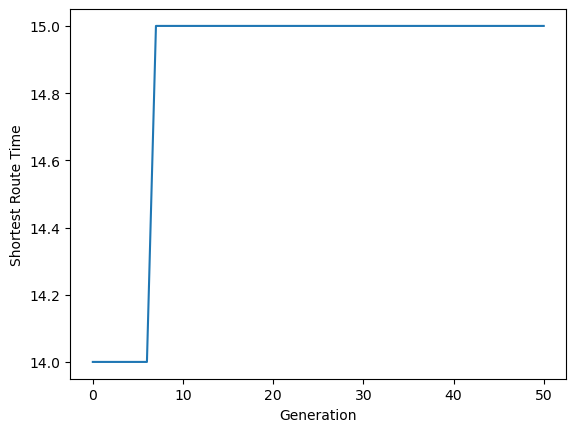

Final shortest time: 15.0
Best route: [El Rosario, Instituto del Petroleo, La Raza, Consulado, Morelos, Candelaria, San Lazaro]


In [61]:
# Define a dictionary to store each station as an object of the Station class.
stations = {
    # Each Station object is initialized with its name and a dictionary of neighboring stations with travel times.
    # Repeat for each station in the network. The keys are station names, values are Station objects with neighbors and times.
    'El Rosario': Station('El Rosario', {'Tacuba': 4, 'Instituto del Petroleo': 6}),
    'Instituto del Petroleo': Station('Instituto del Petroleo', {'El Rosario': 6, 'Deportivo 18 de Marzo': 2, 'La Raza': 2 }),
    'Deportivo 18 de Marzo': Station('Deportivo 18 de Marzo', {'Instituto del Petroleo': 2 , 'La Raza': 2, 'Martin Carrera': 2 }),
    'Martin Carrera': Station('Martin Carrera', {'Deportivo 18 de Marzo': 2, 'Consulado': 3 }),
    'La Raza': Station('La Raza', {'Deportivo 18 de Marzo': 2, 'Instituto del Petroleo': 2, 'Guerrero': 2, 'Consulado': 3 }),
    'Tacuba': Station('Tacuba', {'El Rosario': 4, 'Hidalgo': 7, 'Tacubaya': 5 }),
    'Consulado': Station('Consulado', {'La Raza': 3, 'Martin Carrera': 3, 'Oceania': 3, 'Morelos': 2 }),
    'Guerrero': Station('Guerrero', {'La Raza': 2, 'Garibaldi': 1, 'Hidalgo': 1 }),
    'Garibaldi': Station('Garibaldi', {'Guerrero': 1, 'Morelos': 3, 'Bellas Artes': 1 }),
    'Morelos': Station('Morelos', {'Garibaldi': 3, 'Consulado': 2, 'San Lazaro': 1, 'Candelaria': 1 }),
    'Oceania': Station('Oceania', {'Consulado': 3, 'Pantitlan': 3, 'San Lazaro': 3 }),
    'Hidalgo': Station('Hidalgo', {'Tacuba': 7, 'Guerrero': 1, 'Bellas Artes': 1, 'Balderas': 2 }),
    'Bellas Artes': Station('Bellas Artes', {'Hidalgo': 1, 'Garibaldi': 1, 'Pino Suarez': 3, 'Salto del Agua': 2 }),
    'Balderas': Station('Balderas', {'Hidalgo': 2, 'Salto del Agua': 1, 'Centro Medico': 3, 'Tacubaya': 6 }),
    'Salto del Agua': Station('Salto del Agua', {'Bellas Artes': 2, 'Pino Suarez': 2, 'Chabacano': 3, 'Balderas': 1}),
    'Pino Suarez': Station('Pino Suarez', {'Bellas Artes': 3, 'Candelaria': 2, 'Chabacano': 2, 'Salto del Agua': 2 }),  
    'Candelaria': Station('Candelaria', {'Morelos': 1, 'San Lazaro': 1, 'Jamaica': 2, 'Pino Suarez': 2 }),
    'San Lazaro': Station('San Lazaro', {'Morelos': 1, 'Oceania': 3, 'Pantitlan': 6, 'Candelaria': 1 }),
    'Pantitlan': Station('Pantitlan', {'Oceania': 3, 'Jamaica': 5, 'San Lazaro': 6 }),
    'Tacubaya': Station('Tacubaya', {'Tacuba': 5, 'Balderas': 6, 'Centro Medico': 3, 'Mixcoac': 3 }),
    'Centro Medico': Station('Centro Medico', {'Balderas': 3, 'Chabacano': 2, 'Zapata': 4, 'Tacubaya': 3 }),
    'Chabacano': Station('Chabacano', {'Pino Suarez': 2, 'Jamaica': 1, 'Atlalilco': 8, 'Ermita': 6, 'Centro Medico': 2, 'Salto del Agua': 3 }),
    'Jamaica': Station('Jamaica', {'Candelaria': 2, 'Pantitlan': 5, 'Chabacano': 1 }),
    'Mixcoac': Station('Mixcoac', {'Tacubaya': 3, 'Zapata': 3 }),
    'Zapata': Station('Zapata', {'Centro Medico': 4, 'Ermita': 3, 'Mixcoac': 3 }),
    'Ermita': Station('Ermita', {'Chabacano': 6, 'Atlalilco': 2, 'Zapata': 3 }),
    'Atlalilco': Station('Atlalilco', {'Chabacano': 8, 'Ermita': 2 }),  
}


stationList = [stations[name] for name in stations]
# Create a list of all station objects to facilitate easy access by the genetic algorithm functions.
startStation = stations['El Rosario']
# Define the start station for the genetic algorithm's routing problem.
endStation = stations['San Lazaro']
# Define the end station for the genetic algorithm's routing problem.

bestRoute = geneticAlgorithmPlot(stationList, startStation, endStation, popSize=150, eliteSize=10, mutationRate=0.01, generations=50)
# Call the geneticAlgorithmPlot function which also runs the genetic algorithm but plots the progression of the shortest route time over generations.
print("Best route:", bestRoute)
# Print the best route found by the plotting version of the genetic algorithm.
